Install libraries

In [ ]:
# if you dont already have the required libraries for this notebook, you can install them by running this codeblock
!pip install pandas openpyxl geopandas matplotlib numpy

Import libraries

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

set paths

In [2]:
in_path = os.path.join('..','in')

out_path = os.path.join('..','out')

Load states map shapefile

In [3]:
shapefile_path = os.path.join(in_path,'States_shapefile-shp','States_shapefile.shp')

# Loading custom us state shapefile
states_map = gpd.read_file(shapefile_path)

# We have decided not to include district of columbia in our state mappings, as it is not technically a state.
states_map = states_map[states_map['State_Name'] != 'DISTRICT OF COLUMBIA']

check states shapefile crs!

In [4]:
states_map.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As we can see from the result, we get the WGS84/EPSG:4326 CRS from the shape file. For this reason,, we will also be using that CRS for the rest of the mapping.

# Custom map plotting function

In [5]:
import matplotlib.colors as mcolors
import numpy as np

def plot_us_states(gdf, data_column=None, plot_points=None, title='INSERT TITLE', colormap='RdYlGn', point_color='black', point_size=3, point_opacity=1, label_states=False, colorbar_title=None, log_scale=False, output_file=None):
    fig = plt.figure(figsize=(20, 13))
    fig.suptitle(title, fontsize=24)
    
    # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
    mainland_us = gdf[~gdf['State_Name'].isin(['HAWAII', 'ALASKA'])]
    # Make new geodataframes for each of the excluded states.
    alaska = gdf[gdf['State_Name'] == 'ALASKA']
    hawaii = gdf[gdf['State_Name'] == 'HAWAII']

# Normalize the color map based on the entire dataset
    if data_column:
        if log_scale:
            #if user is choosing to plot on a logarithmic scale, normalize the data values logarithmically 
            norm = mcolors.LogNorm(vmin=gdf[data_column].replace(0, np.nan).min(), vmax=gdf[data_column].max())
        else:
            # if user hasnt specified logarithmi scale, normalize the values as normal
            norm = mcolors.Normalize(vmin=gdf[data_column].min(), vmax=gdf[data_column].max())

    # Create a new axis for mainland US
    ax_mainland = fig.add_axes([0, 0.05, 1, 1])  # [x, y, width, height]
    if data_column:
        # Plot mainland US with data column
        mainland_us.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=ax_mainland, edgecolor='0.5', legend=False, missing_kwds={'color': 'lightgrey'})
    else:
        # Plot mainland US without data column (all states in gray)
        mainland_us.plot(color='lightgrey', linewidth=0.8, ax=ax_mainland, edgecolor='0.5')

    # Add Alaska Axis (x, y, width, height)
    akax = fig.add_axes([-0.05, 0.1, 0.3, 0.3])
    if data_column:
        # Plot Alaska with data column
        alaska.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=akax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    else:
        # Plot Alaska without data column (all states in gray)
        alaska.plot(color='lightgrey', linewidth=0.8, ax=akax, edgecolor='0.5')
    akax.set_title('Alaska', fontsize=20)
    
    # Add Hawaii Axis (x, y, width, height)
    hiax = fig.add_axes([0.225, 0.15, 0.15, 0.15])
    if data_column:
        # Plot Hawaii with data column
        hawaii.plot(column=data_column, cmap=colormap, norm=norm, linewidth=0.8, ax=hiax, edgecolor='0.5', missing_kwds={'color': 'lightgrey'})
    else:
        # Plot Hawaii without data column (all states in gray)
        hawaii.plot(color='lightgrey', linewidth=0.8, ax=hiax, edgecolor='0.5')
    hiax.set_title('Hawaii', fontsize=20)

    # Hide all axes borders and labels
    ax_mainland.set_axis_off()
    akax.set_axis_off()
    hiax.set_axis_off()

    # If plotting datacenter locations, make a new geodataframe for datacenter point locations for the mainland, Alaska and Hawaii
    if plot_points is not None:
        # Exclude Hawaii and Alaska when making the initial mainland/contiguous plot
        mainland_us_dc = plot_points[~plot_points['state'].isin(['Hawaii', 'Alaska'])]
        # We only have to make a datacenter gdf for Hawaii, since Alaska doesn't have any datacenters of its own!
        # again we dont include district of columbia
        hawaii_dc = plot_points[plot_points['state'] == 'Hawaii']

        # Plot the data points on the mainland map
        mainland_us_dc.plot(ax=ax_mainland, color=point_color, markersize=point_size, alpha=point_opacity)
        
        # Plot the data points on the Hawaii map
        hawaii_dc.plot(ax=hiax, color=point_color, markersize=point_size, alpha=point_opacity)

    if label_states and data_column:
        label_size = 15
        for idx, row in mainland_us.iterrows():
            #f"{row[data_column]:.2f}".rstrip('0').rstrip('.') rounds to 2 decimal places, and if the float value is an integer value, e.g. 23.00, we strip the 0's
            ax_mainland.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                             s=f"{row[data_column]:.2f}".rstrip('0').rstrip('.'), horizontalalignment='center', fontsize=label_size)

        if not alaska.empty:
            row = alaska.iloc[0]
            akax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                      s=f"{row[data_column]:.2f}".rstrip('0').rstrip('.'), horizontalalignment='center', fontsize=label_size)
        
        if not hawaii.empty:
            row = hawaii.iloc[0]
            hiax.text(row.geometry.centroid.x, row.geometry.centroid.y, 
                      s=f"{row[data_column]:.2f}".rstrip('0').rstrip('.'), horizontalalignment='center', fontsize=label_size)

    if data_column:
        # Create an axis for the colorbar
        cax = fig.add_axes([0.05, 0.07, 0.9, 0.02])  # [x, y, width, height]
        # Create a ScalarMappable for the colorbar based on the colormap and normalization of the data values.
        sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm._A = []  # This is needed for ScalarMappable
        # Give the colorbar a title named after the data column we are plotting
        if colorbar_title == None:
           colorbar_title = data_column
        cax.set_title(colorbar_title, fontsize=20)
        cax.tick_params(labelsize=20)
        fig.colorbar(sm, cax=cax, orientation='horizontal')

    if output_file is not None:
        plt.savefig(os.path.join(out_path, output_file))

    plt.show()


# Data center locations

In [6]:
dc_file = os.path.join(in_path,'datacenters_usa_clean.csv')

#dc_df = datacenter_dataframe
dc_df = pd.read_csv(dc_file)

# Create a GeoDataFrame
dc_gdf = gpd.GeoDataFrame(dc_df, geometry=gpd.points_from_xy(dc_df.longitude, dc_df.latitude))

# Setting the coordinate reference system (CRS)
# As determinged before, we will be using the WGS84/EPSG4326 crs, so that it fits the shapefile.
dc_gdf.crs = "EPSG:4326"

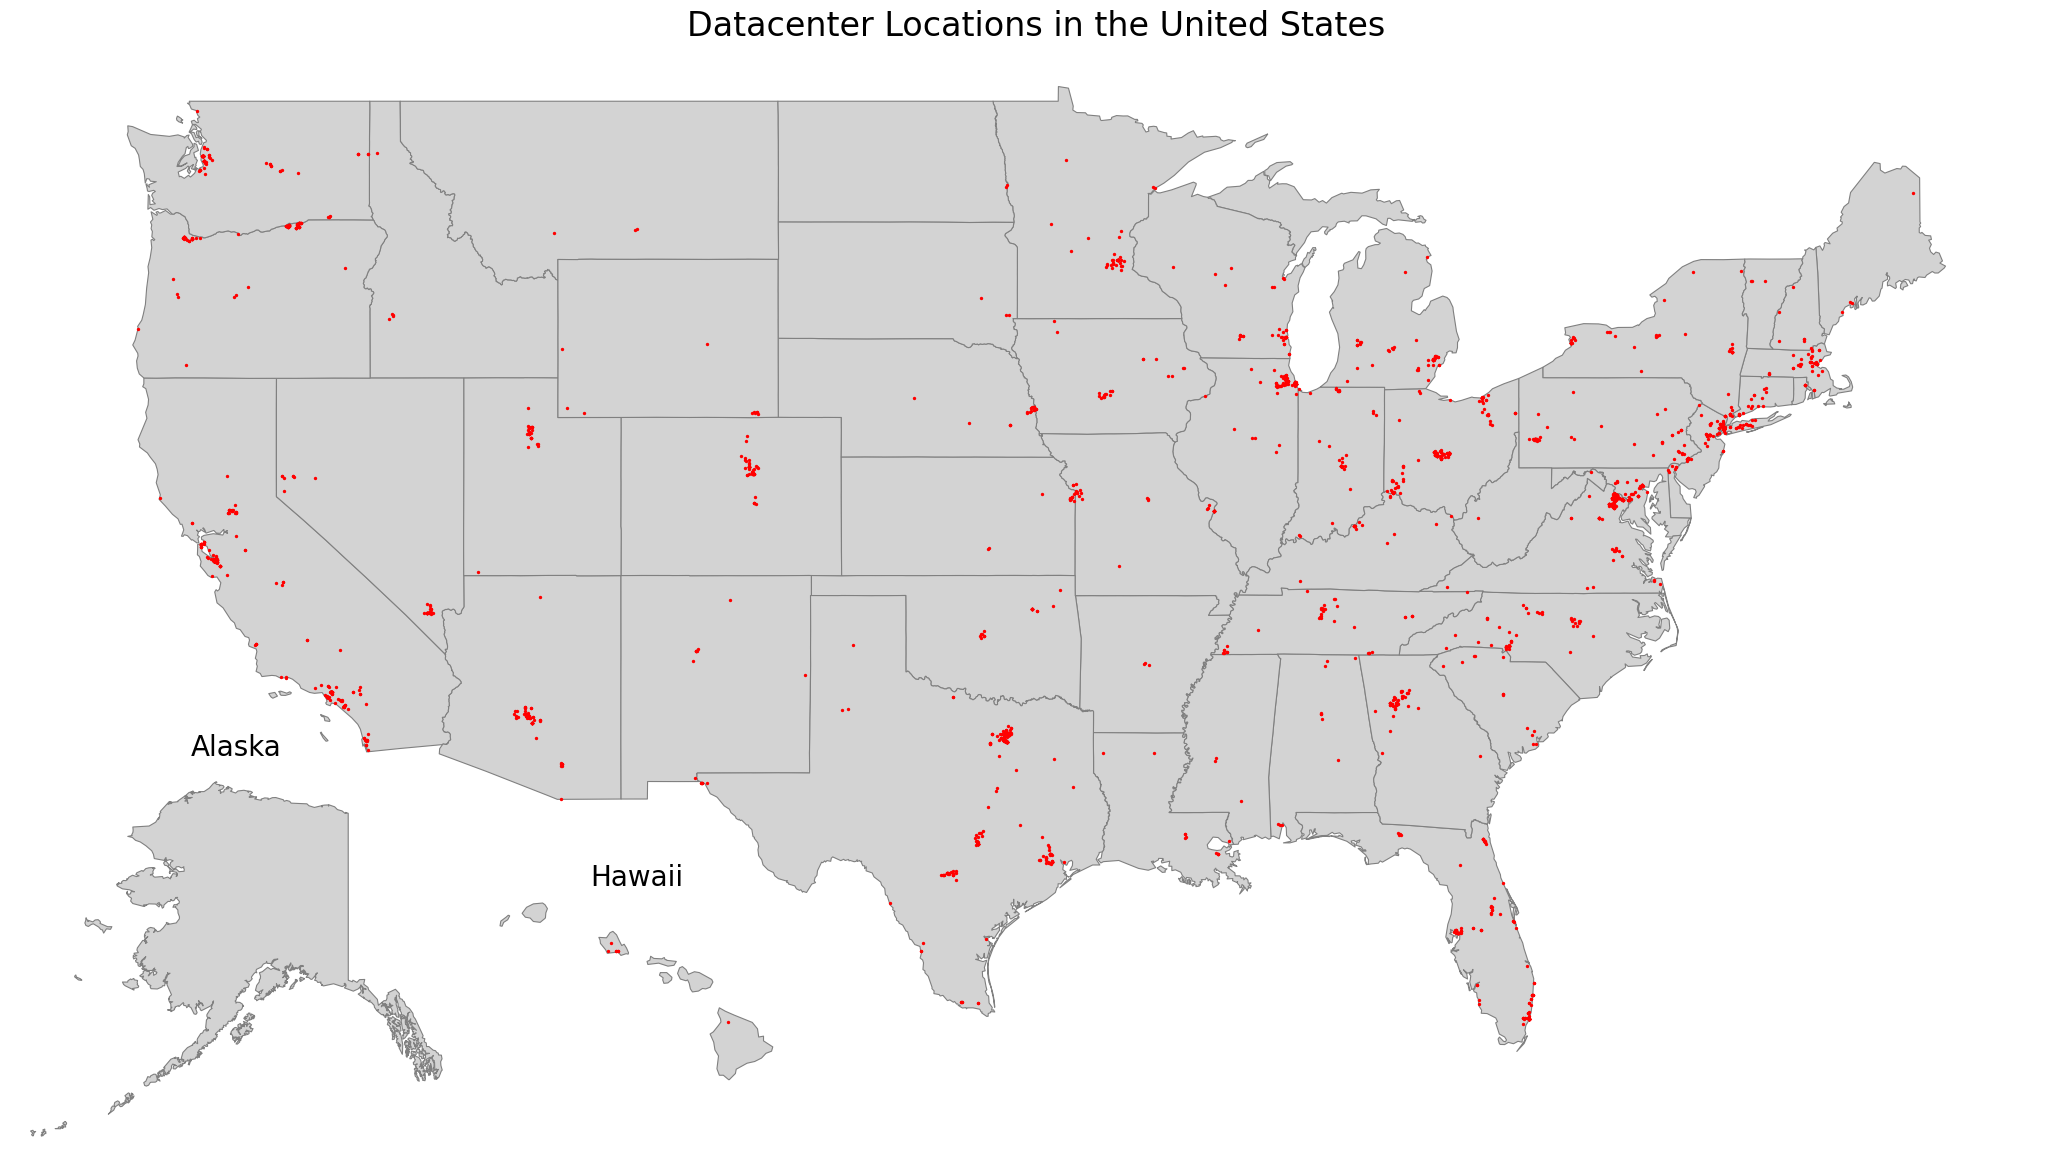

In [7]:
plot_us_states(states_map, 
               title='Datacenter Locations in the United States', 
               plot_points=dc_gdf, 
               point_color='red',
               point_size=2,
               output_file='data center locations.png')

# Data center count by state

In [8]:
def uppercase_df(input_df):
    return input_df.map(lambda x: x.upper() if isinstance(x, str) else x)

In [9]:
state_counts = dc_df['state'].value_counts().reset_index()
# Convert all string values in the dataframe to uppercase since the shapefile uses uppercase state names
state_counts = uppercase_df(state_counts)
state_counts.columns = ['State_Name', 'Datacenter_Count']

In [10]:
# Merge the state counts with the state shapefile map based on state names
map_data = states_map.merge(state_counts, how='left', on='State_Name')

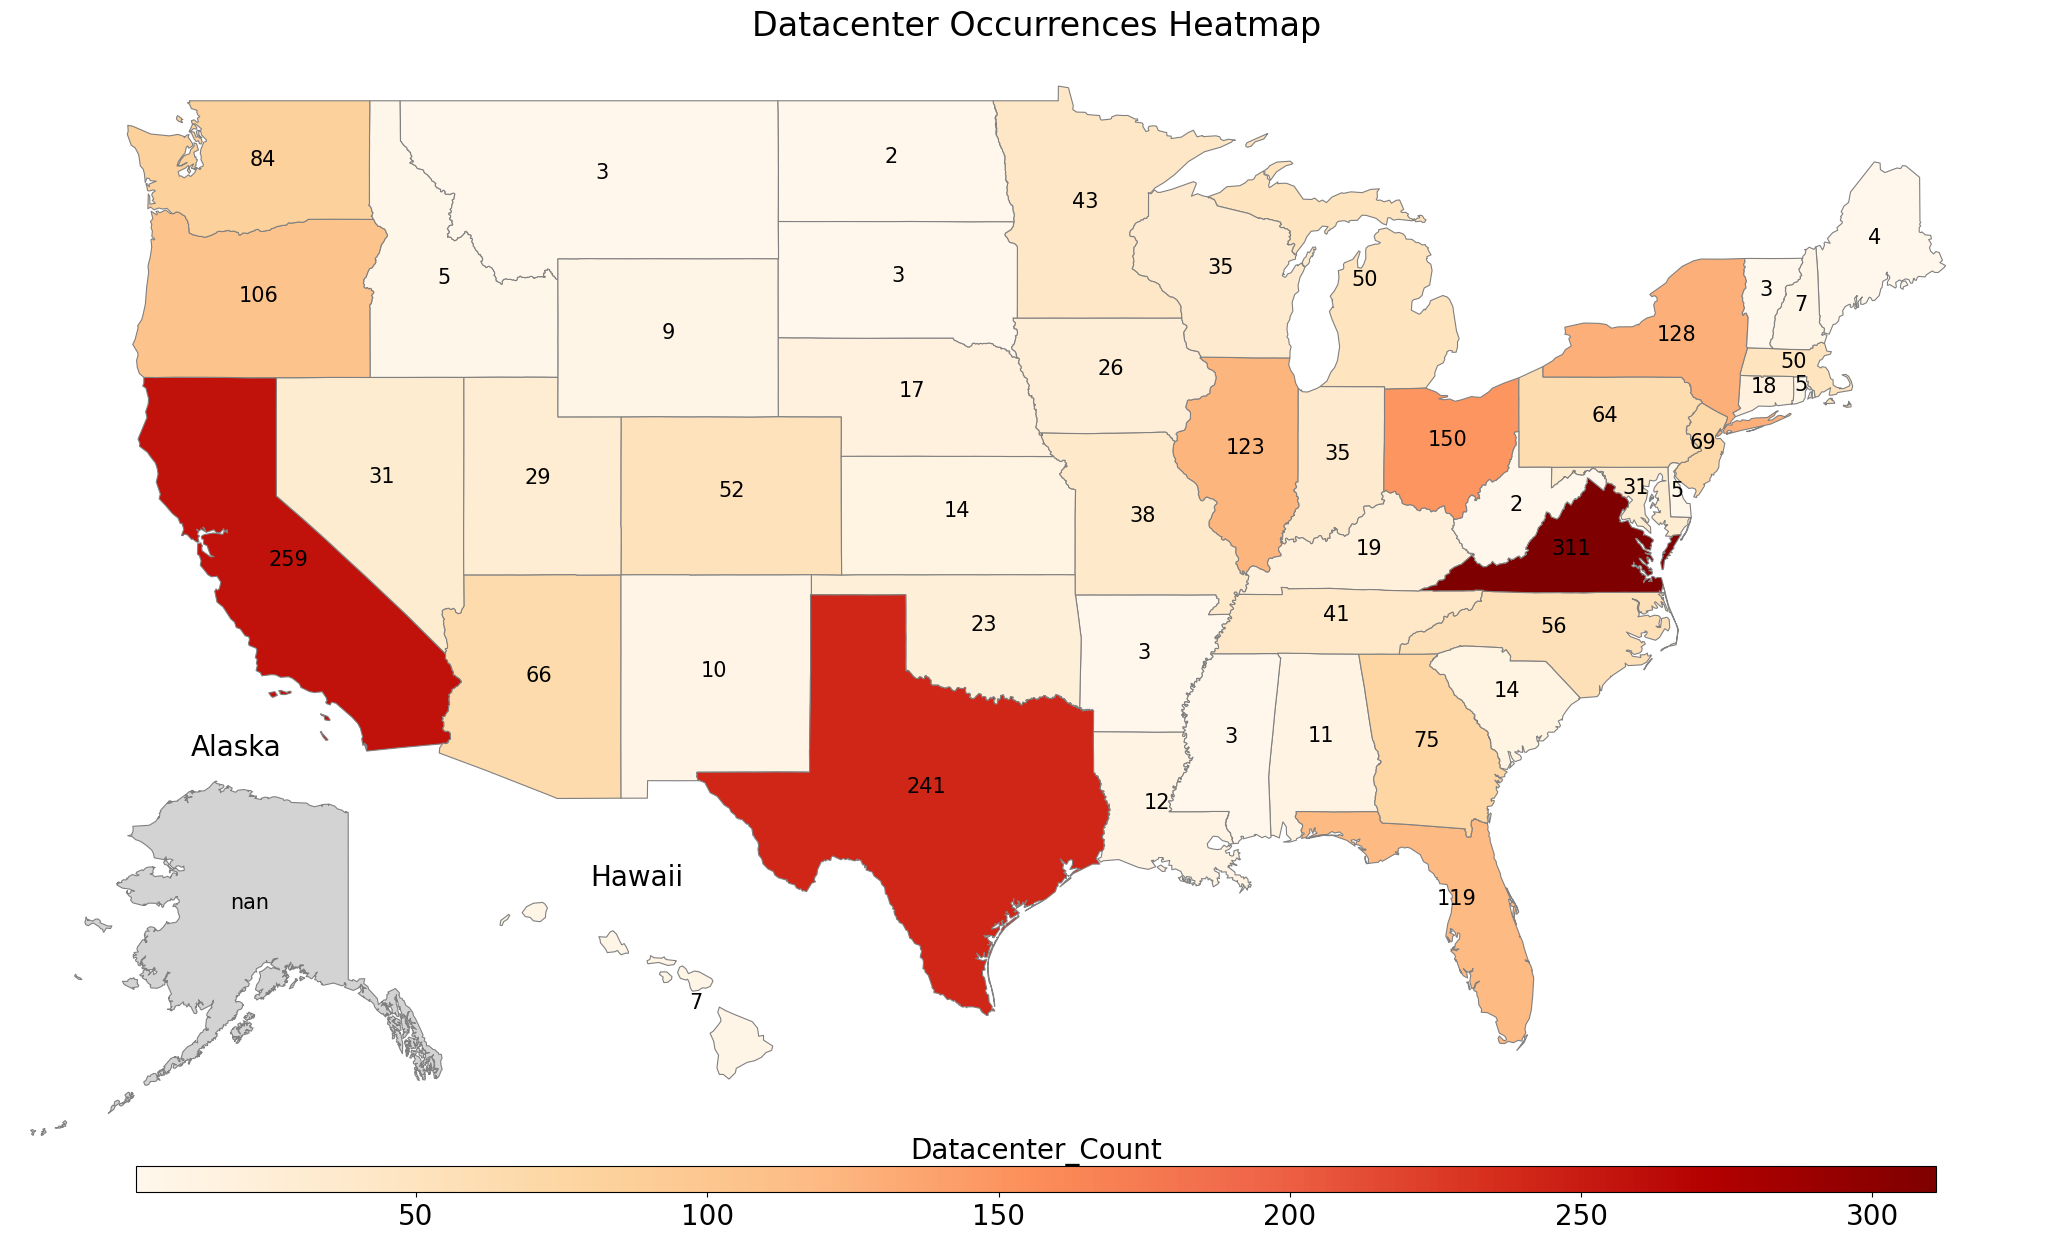

In [11]:
data_column = 'Datacenter_Count'

title = f'Datacenter Occurrences Heatmap'

plot_us_states(map_data, 
               data_column, 
               title=title, 
               colormap='OrRd', 
               label_states=True,
               output_file='data center heatmap.png')

# State Power Pricing

In [12]:
power_df = pd.read_excel(os.path.join(in_path, 'avgprice_annual.xlsx'), skiprows=1)

#only keeping power prices from 2020
power_df = power_df[power_df['Year'] == 2020]

#only keeping "total electric industry" as the industry sector as its the only one that has all 51 states.
power_df = power_df[power_df['Industry Sector Category'] == 'Total Electric Industry']

power_df.rename(columns={'State': 'State_Code',
                         'Industrial': 'Industrial power price'}, inplace=True)

# Only keeping the columns of the state code and the 
power_df = power_df[['State_Code','Industrial power price']]

power_df.head()

,State_Code,Industrial power price
0,AK,15.88
1,AL,5.87
2,AR,5.89
3,AZ,6.07
4,CA,14.27


In [13]:
#Merging the power_df into the map_data.
#Merge them based on the "state_code" colmuns
map_data = map_data.merge(power_df, how='left', on='State_Code')

map_data.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Datacenter_Count,Industrial power price
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",11.0,5.87
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",NaN,15.88
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",66.0,6.07
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.0,5.89
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",259.0,14.27


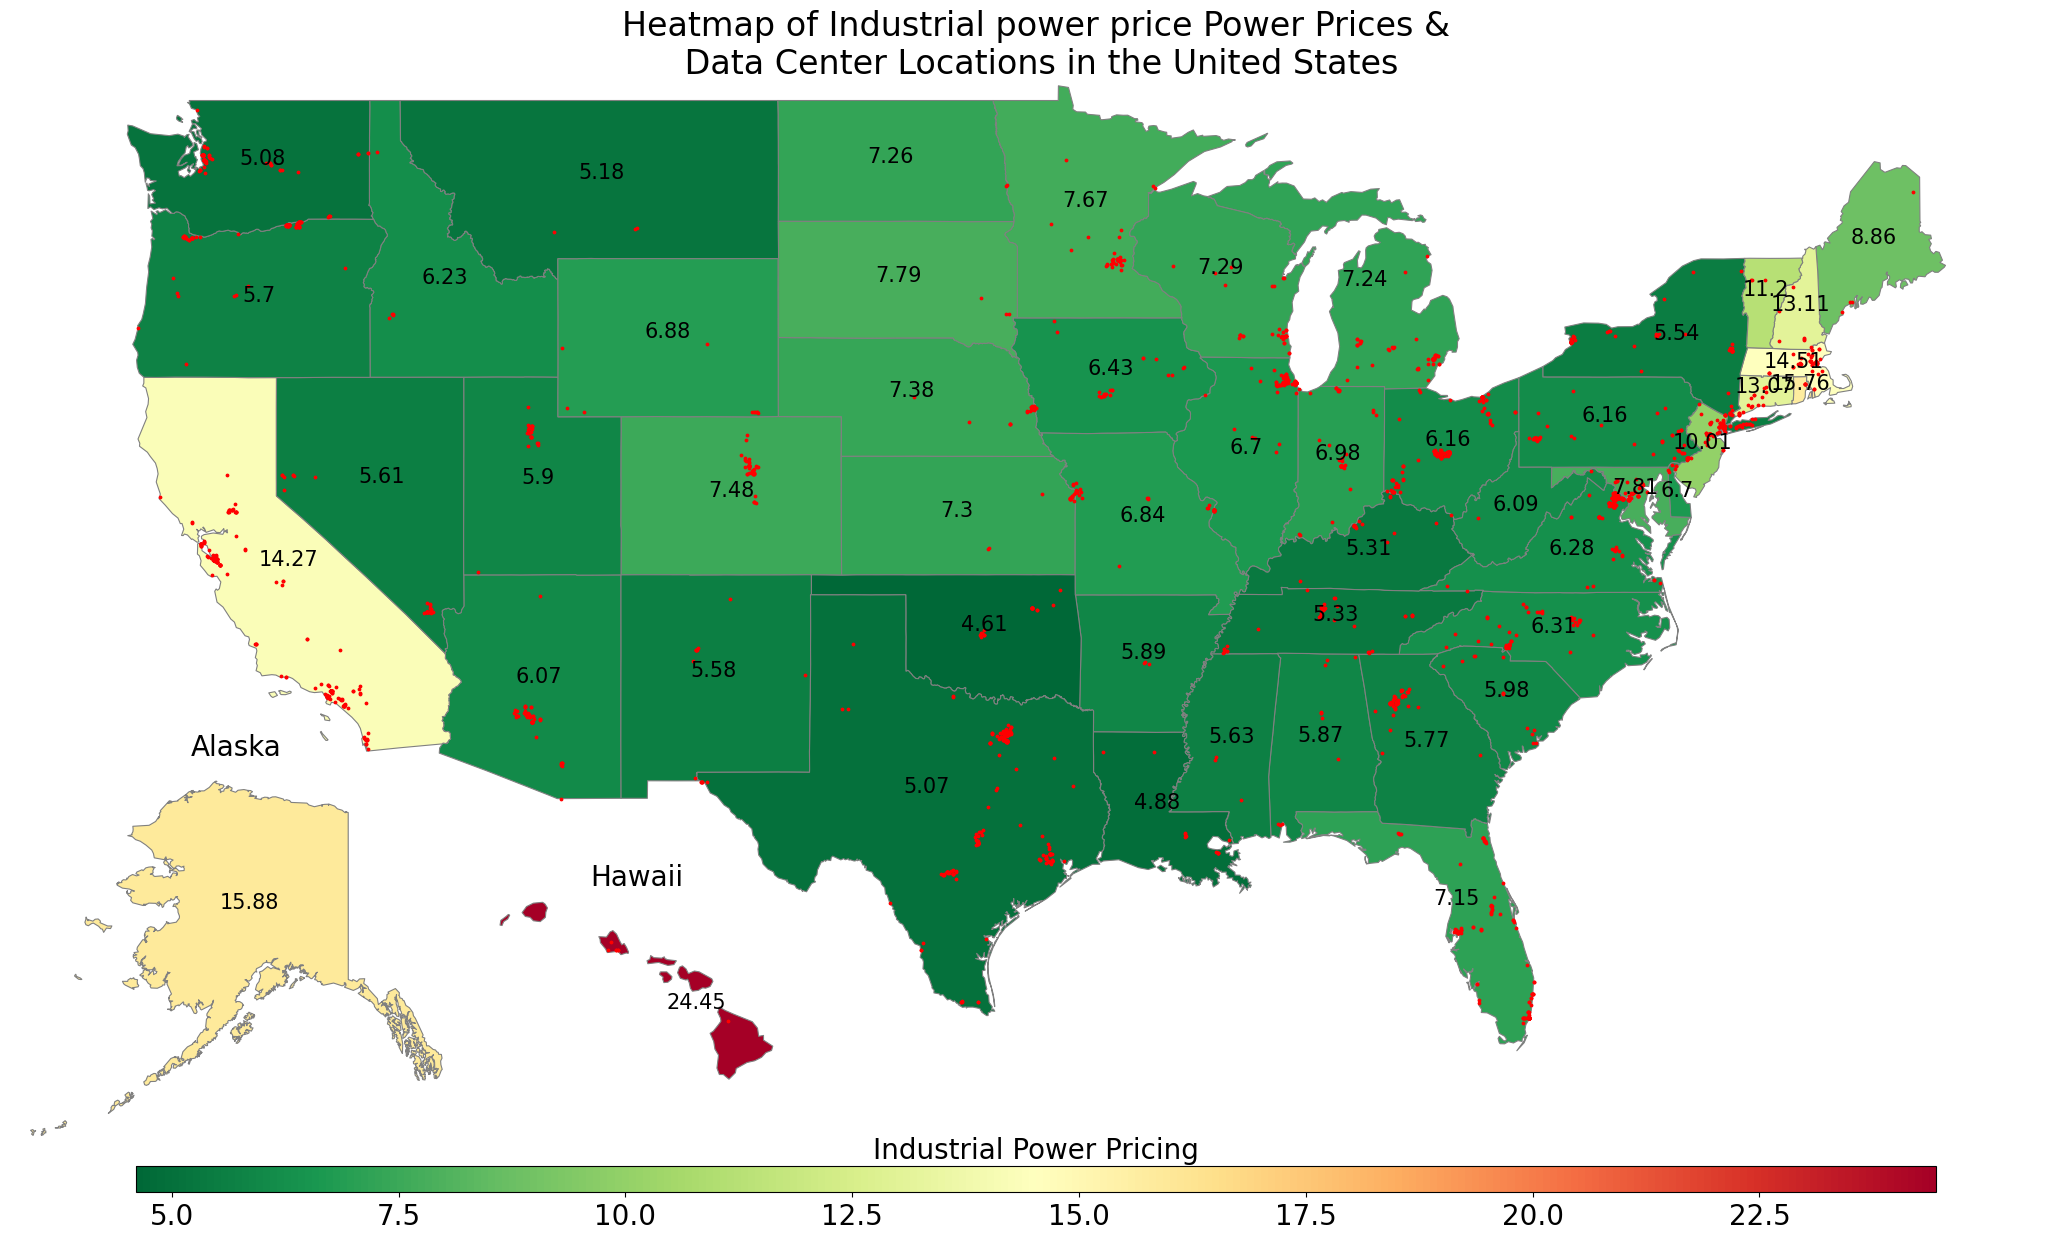

In [14]:
power_sector = 'Industrial power price'

title = f'Heatmap of {power_sector} Power Prices &\n Data Center Locations in the United States'

plot_us_states(map_data, power_sector, 
               title=title, 
               colorbar_title='Industrial Power Pricing',
               label_states=True,
               plot_points=dc_gdf, 
               point_color='red',
               colormap='RdYlGn_r',
               output_file='industrial power price and datacenter locations.png')

# Renewable energy by state

In [15]:
green_states_file = os.path.join(in_path,'green_states.csv')
green_states = pd.read_csv(green_states_file)
green_states.head()

,State,Renewable,Renewable rank,% Coal,% Gas,% Nuclear,% Hydro,% Wind,% Solar
0,South Dakota,83%,1,9%,7%,0%,29%,54%,0%
1,Vermont,76%,2,0%,0%,0%,52%,16%,8%
2,Washington,74%,3,3%,15%,8%,66%,9%,0%
3,Idaho,69%,4,0%,29%,0%,49%,17%,3%
4,Oregon,64%,5,0%,35%,0%,46%,16%,2%


In [16]:
def remove_trailing_space_df(input_df):
    return input_df.map(lambda x: x.strip() if isinstance(x, str) else x)

In [17]:
green_states.rename(columns={'State' : 'State_Name'},
                            inplace=True)
green_states = uppercase_df(green_states)
green_states = remove_trailing_space_df(green_states)
green_states=green_states[['State_Name','Renewable']]
green_states.head()

,State_Name,Renewable
0,SOUTH DAKOTA,83%
1,VERMONT,76%
2,WASHINGTON,74%
3,IDAHO,69%
4,OREGON,64%


In [18]:
green_states['Renewable'] = green_states['Renewable'].str.rstrip('%').astype(float)

In [19]:
map_data = map_data.merge(green_states, how='left', on='State_Name')

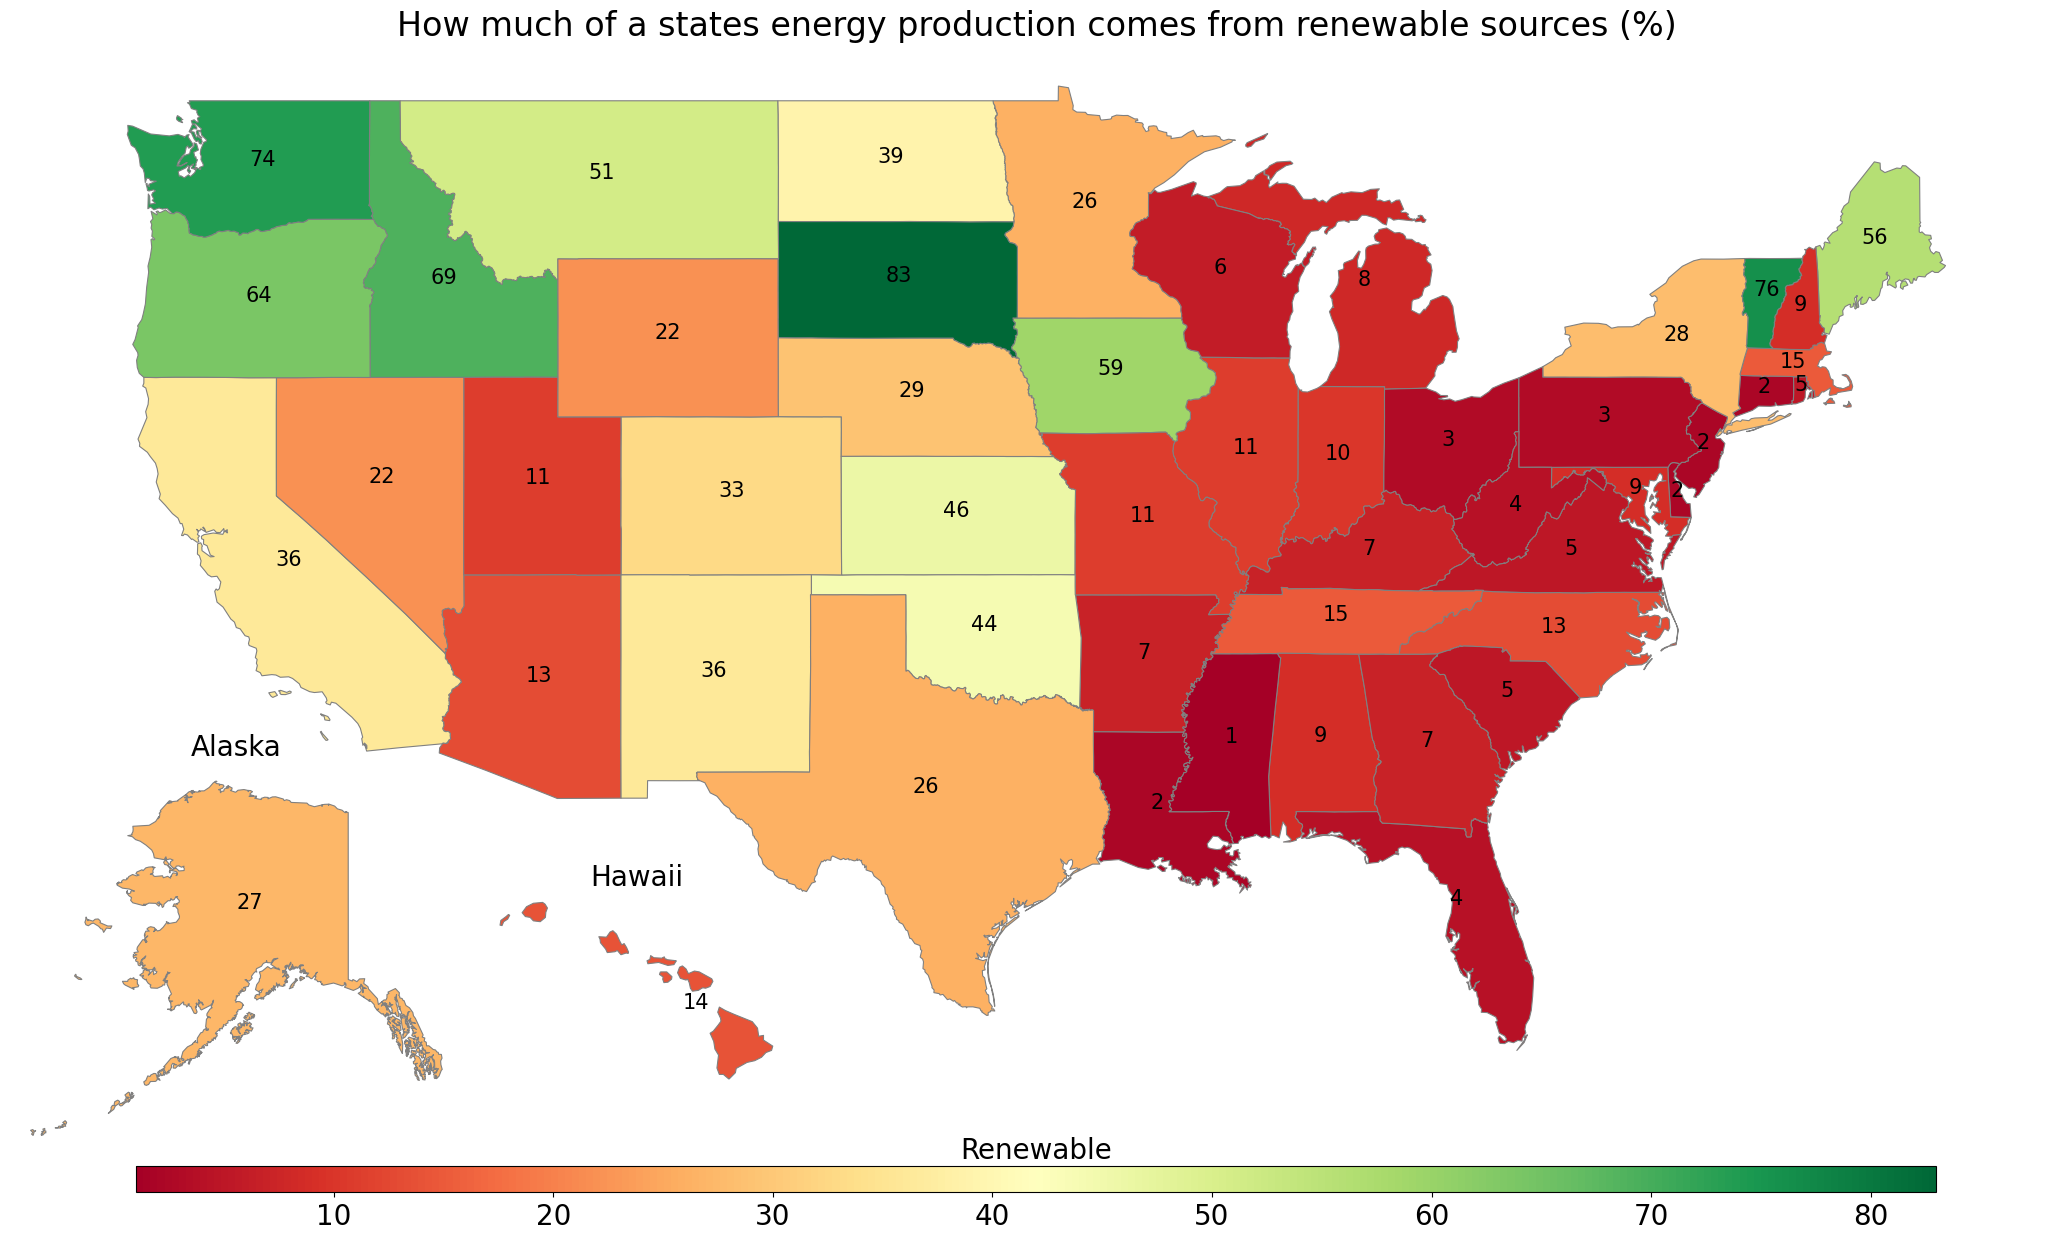

In [20]:
data_column = 'Renewable'

title = f'How much of a states energy production comes from renewable sources (%)'

plot_us_states(map_data,
               data_column,
               title=title,
               colormap='RdYlGn',
               label_states=True,
               output_file='renewable energy by state.png')

## State temperatures

First, we import the average annual temperature by states for 2023.

In [21]:
state_temp_file = os.path.join(in_path,'state_temp.csv')
state_temp = pd.read_csv(state_temp_file, skiprows=4)
state_temp.head()

,ID,Name,Value,Anomaly (1901-2000 base period),Rank,1901-2000 Mean
0,1,Alabama,65.4,2.3,127,63.1
1,2,Arizona,60.8,1.4,105,59.4
2,3,Arkansas,62.9,2.5,126,60.4
3,4,California,58.2,0.8,92,57.4
4,5,Colorado,45.9,1.3,101,44.6


Then, we rename the "name" colum to "State_Name" and the "value" column to "temperature".

In [22]:
state_temp.rename(columns={'Name' : 'State_Name', 'Value' : 'temperature'}, inplace=True)

state_temp = state_temp[['State_Name','temperature']]

#converting to uppercase again, because thats what the map_data shapefile uses for state names.
state_temp = uppercase_df(state_temp)

state_temp.head()

,State_Name,temperature
0,ALABAMA,65.4
1,ARIZONA,60.8
2,ARKANSAS,62.9
3,CALIFORNIA,58.2
4,COLORADO,45.9


Adding missing temperatures manually to each state

Alaska:
https://www.ncei.noaa.gov/access/monitoring/monthly-report/national/202313 

Hawaii:
https://www.usclimatedata.com/climate/honolulu/hawaii/united-states/ushi0026

Washington DC:
https://www.weather.gov/media/lwx/climate/dcatemps.pdf 

In [23]:
# Calculates the average of the annual high temperature and annual low temperature for Honolulu, Hawaii
avg_temp_hawaii = (84+71)/2

# Creates a data frame with the missing states and their average tempeatures 
missing_states = pd.DataFrame({
    'State_Name': ['ALASKA', 'DISTRICT OF COLUMBIA', 'HAWAII'],
    'temperature': [28.4, 61.2, avg_temp_hawaii]
})

state_temp = pd.concat([state_temp, missing_states])

state_temp.head()

,State_Name,temperature
0,ALABAMA,65.4
1,ARIZONA,60.8
2,ARKANSAS,62.9
3,CALIFORNIA,58.2
4,COLORADO,45.9


Then we convert the temperatures from fahrenheit to celsius by applying a custom funtion to the column.

In [24]:
def fahrenheit_to_celsius(fahrenheit):
    """
    Convert Fahrenheit to Celsius.

    Parameters:
    fahrenheit (float): Temperature in Fahrenheit.

    Returns:
    float: Temperature in Celsius.
    """
    celsius = (fahrenheit - 32) * 5.0/9.0
    return celsius

state_temp['temperature'] = state_temp['temperature'].apply(fahrenheit_to_celsius)

state_temp.head()

,State_Name,temperature
0,ALABAMA,18.555556
1,ARIZONA,16.000000
2,ARKANSAS,17.166667
3,CALIFORNIA,14.555556
4,COLORADO,7.722222


In [25]:
map_data = map_data.merge(state_temp, how='left', on='State_Name')

map_data.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Datacenter_Count,Industrial power price,Renewable,temperature
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",11.0,5.87,9.0,18.555556
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",NaN,15.88,27.0,-2.000000
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",66.0,6.07,13.0,16.000000
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.0,5.89,7.0,17.166667
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",259.0,14.27,36.0,14.555556


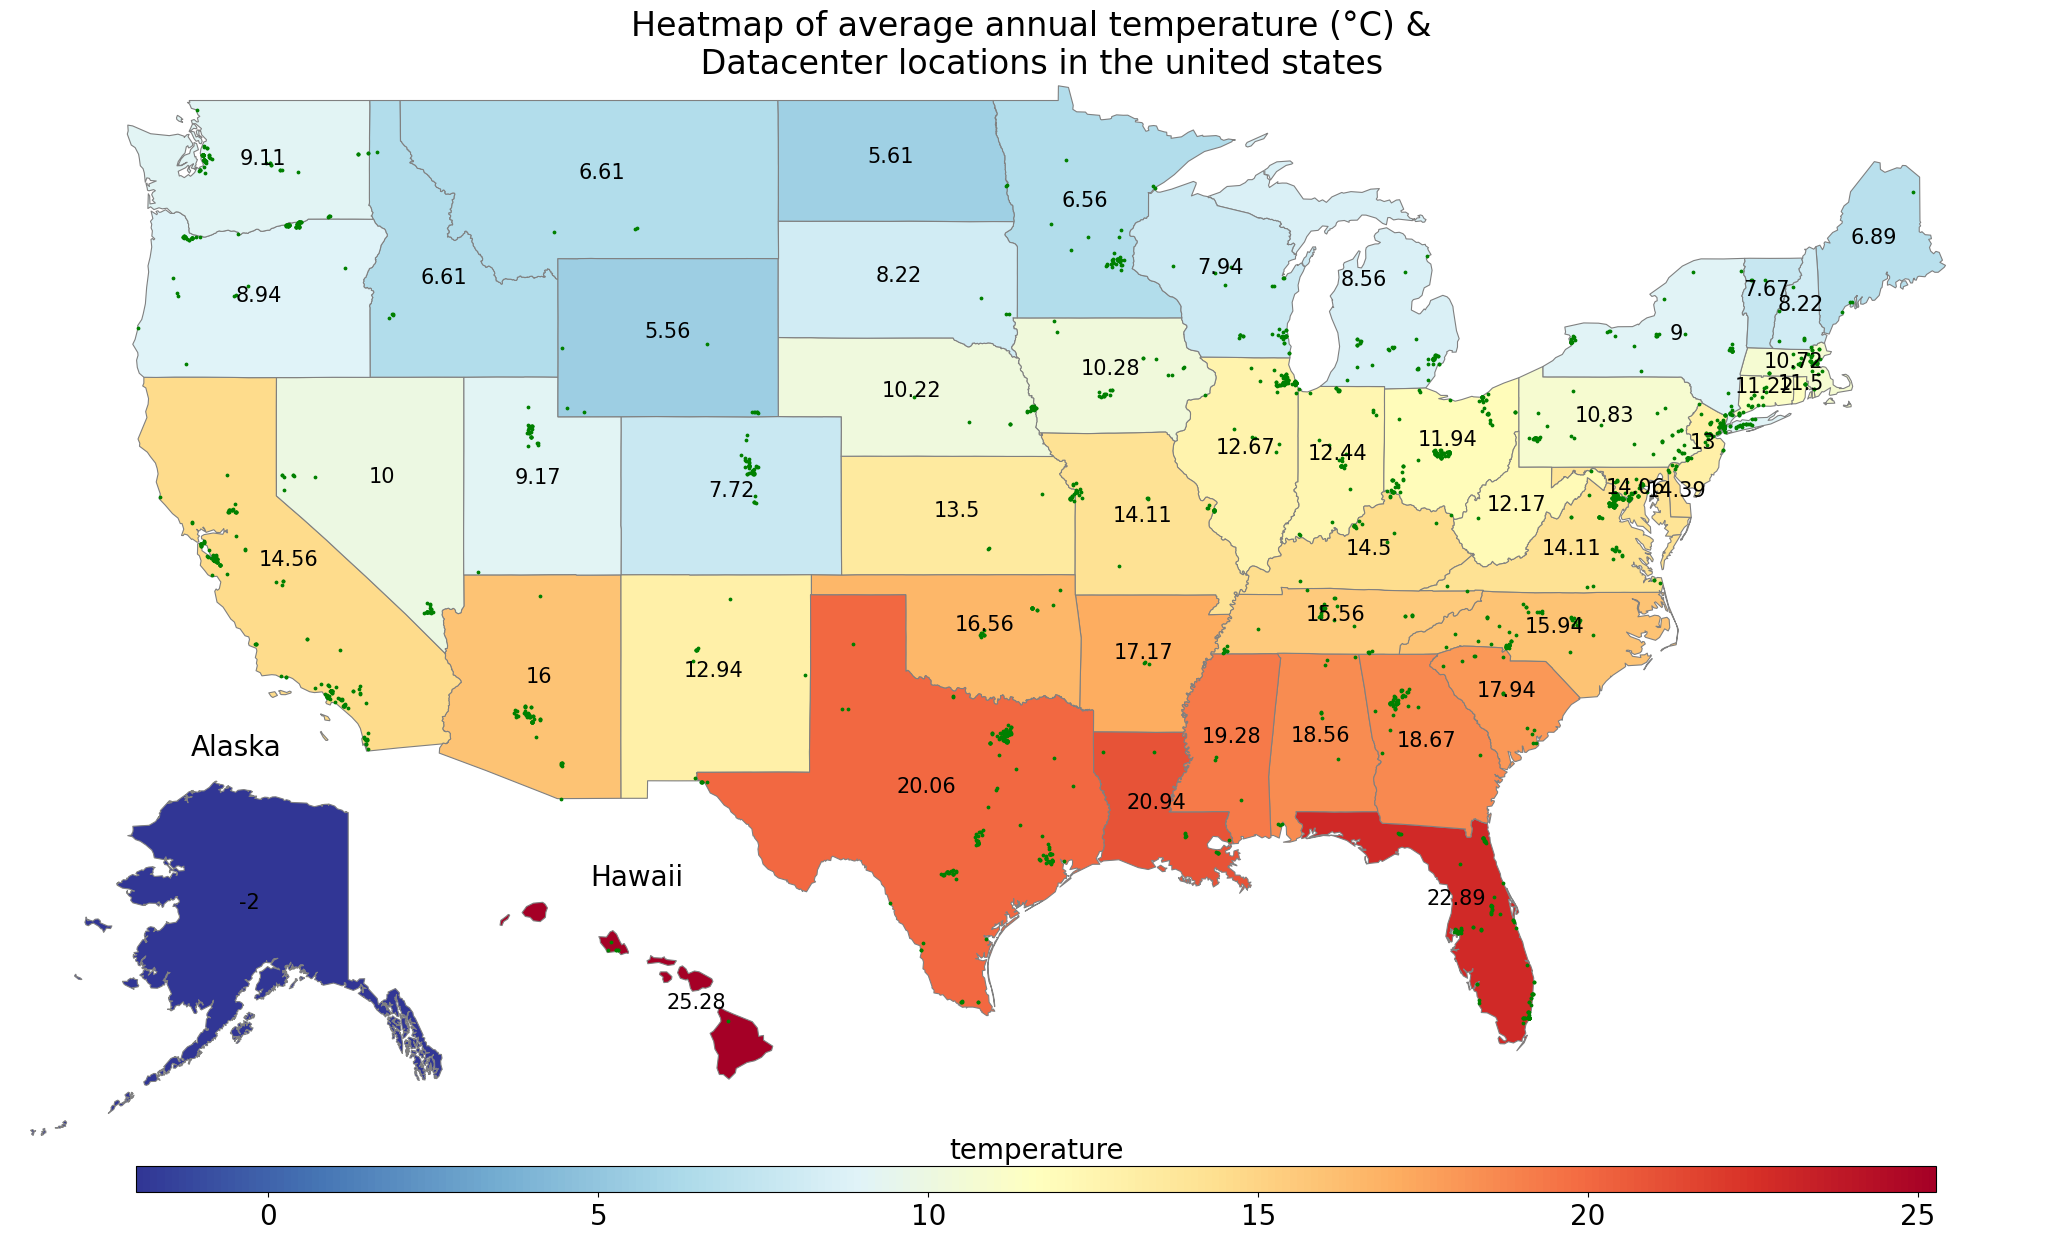

In [26]:
data_column = 'temperature'

title = f'Heatmap of average annual temperature (°C) & \n Datacenter locations in the united states'

plot_us_states(map_data, 
               data_column, 
               plot_points=dc_gdf, 
               point_color='green',
               title=title, 
               colormap='RdYlBu_r',
               label_states=True,
               output_file='avg temperatures and datacenter locations.png')

## Humidity

In [27]:
humidity_file = os.path.join(in_path,'most-humid-states-2024.csv')
state_humidity = pd.read_csv(humidity_file)
state_humidity.head()

,state,MostHumidStatesAverageRelativeHumidity,MostHumidStatesAverageDewPointF
0,Alabama,71.6,54.0
1,Alaska,77.1,26.5
2,Arizona,38.5,32.5
3,Arkansas,70.9,50.7
4,California,61.0,44.2


Renaming the columns

In [28]:
state_humidity.rename(columns={'state' : 'State_Name',
                               'MostHumidStatesAverageRelativeHumidity' : 'relative_humidity',
                               'MostHumidStatesAverageDewPointF' : 'avg_dewpoint'},
                               inplace=True)
state_humidity.head()

,State_Name,relative_humidity,avg_dewpoint
0,Alabama,71.6,54.0
1,Alaska,77.1,26.5
2,Arizona,38.5,32.5
3,Arkansas,70.9,50.7
4,California,61.0,44.2


Converting State_Name column to uppercase, and converting dewpoint from fahrenheit to celsius

In [29]:
state_humidity = uppercase_df(state_humidity)

state_humidity['avg_dewpoint'] = state_humidity['avg_dewpoint'].apply(fahrenheit_to_celsius)

state_humidity.head()

,State_Name,relative_humidity,avg_dewpoint
0,ALABAMA,71.6,12.222222
1,ALASKA,77.1,-3.055556
2,ARIZONA,38.5,0.277778
3,ARKANSAS,70.9,10.388889
4,CALIFORNIA,61.0,6.777778


In [30]:
map_data = map_data.merge(state_humidity, how='left', on='State_Name')

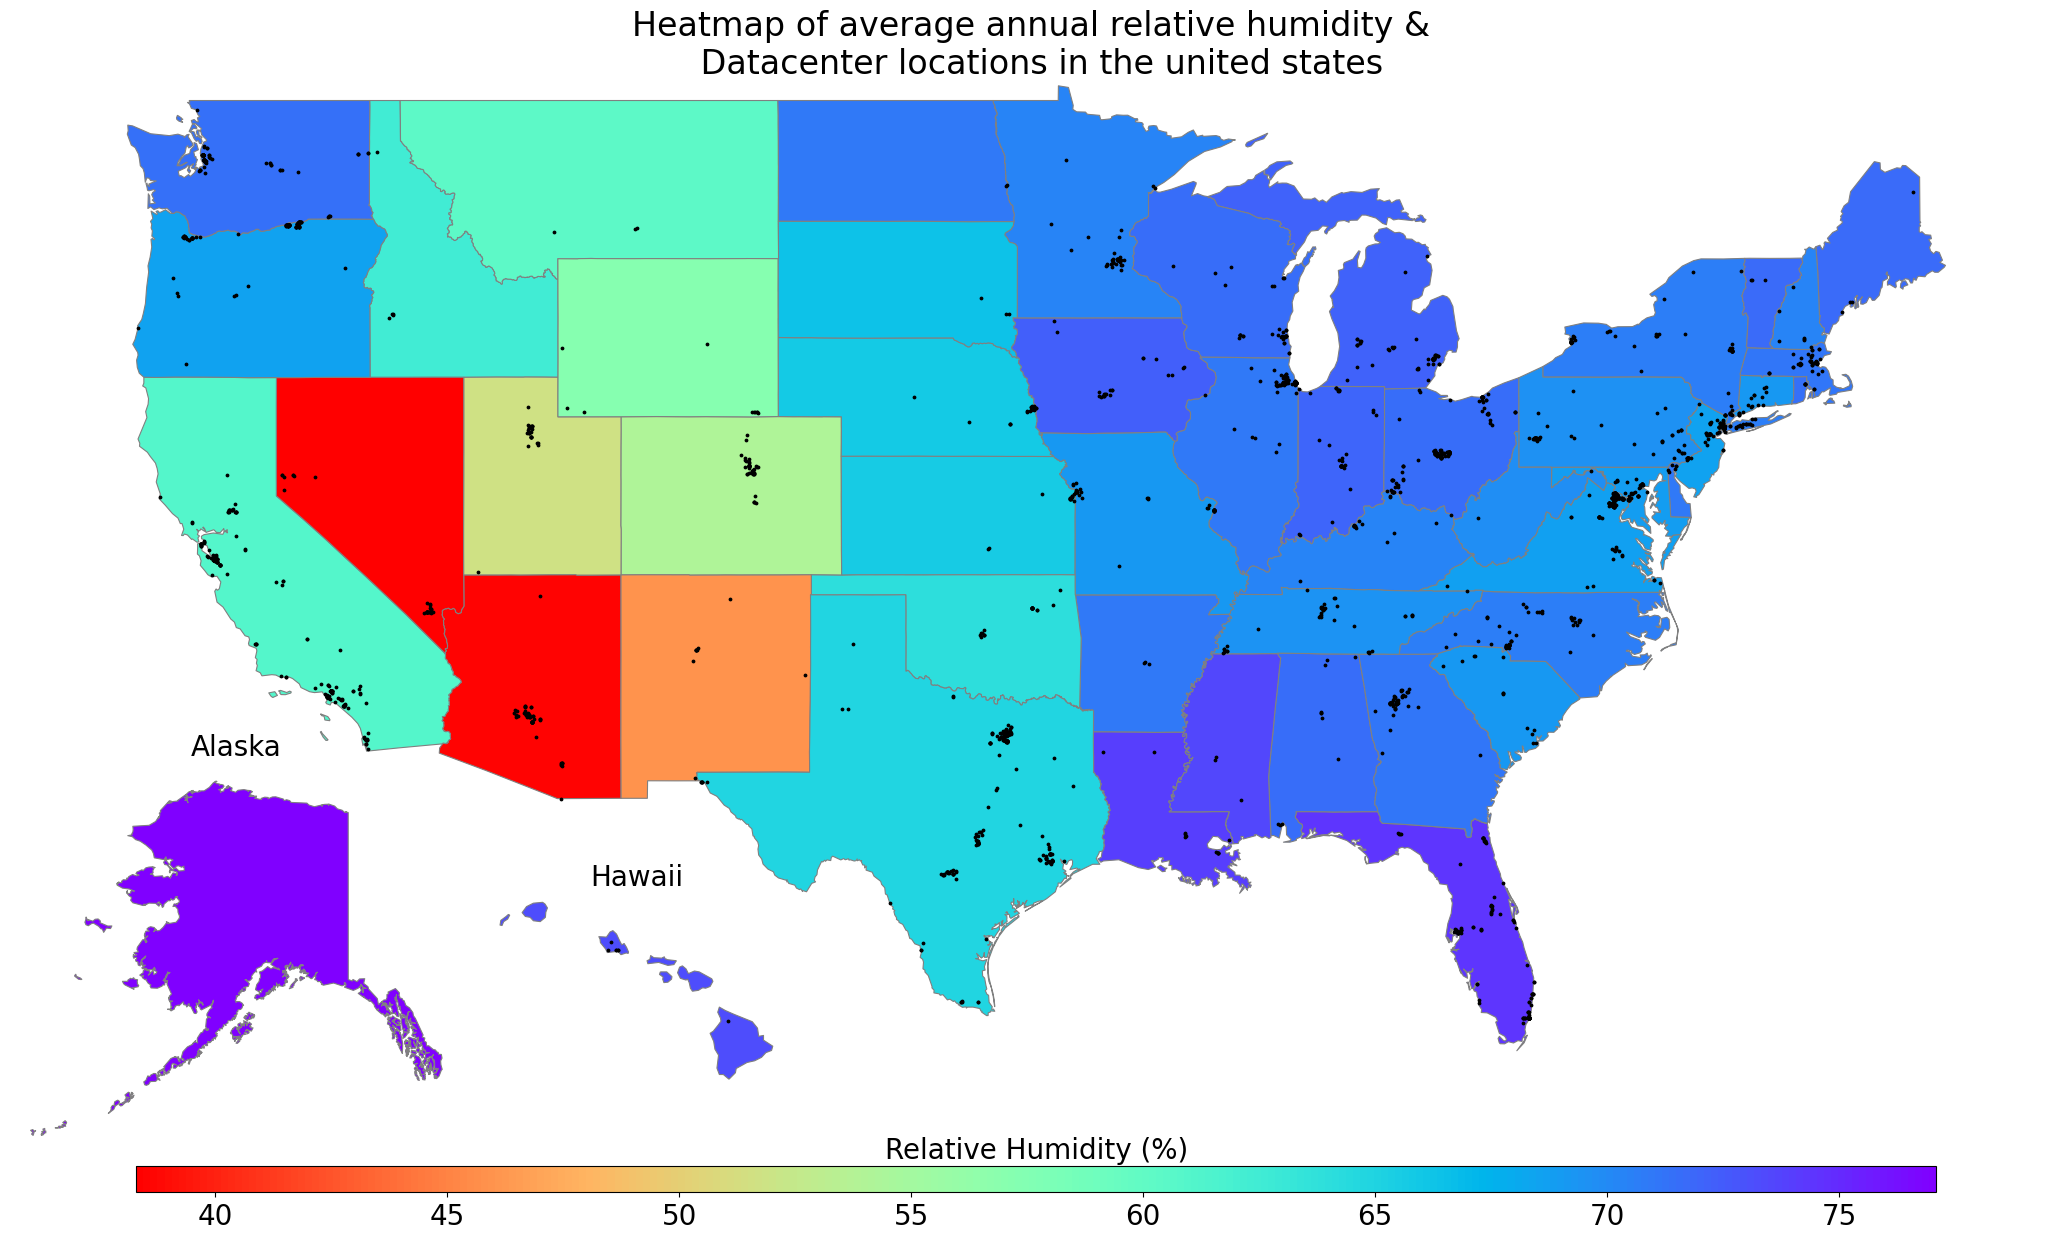

In [31]:
data_column = 'relative_humidity'

title = f'Heatmap of average annual relative humidity & \n Datacenter locations in the united states'

plot_us_states(map_data, data_column, 
               plot_points=dc_gdf, 
               title=title, 
               label_states=False,
               colorbar_title='Relative Humidity (%)',
               colormap='rainbow_r',
               output_file='avg humidity and datacenter locations.png')

# Population density

In [32]:
pop_density_file = os.path.join(in_path,'united-states-by-density-2024.csv')
pop_density = pd.read_csv(pop_density_file)
pop_density.head()

,state,densityMi,population,TotalArea
0,Alabama,101.55066,5143033.0,52420.0
1,Alaska,1.28546,733536.0,665384.0
2,Arizona,65.99824,7497004.0,113990.0
3,Arkansas,59.36504,3089060.0,53179.0
4,California,249.64706,38889770.0,163696.0


In [33]:
pop_density.rename(columns={'state' : 'State_Name'},
                            inplace=True)
pop_density = uppercase_df(pop_density)
pop_density.head()

,State_Name,densityMi,population,TotalArea
0,ALABAMA,101.55066,5143033.0,52420.0
1,ALASKA,1.28546,733536.0,665384.0
2,ARIZONA,65.99824,7497004.0,113990.0
3,ARKANSAS,59.36504,3089060.0,53179.0
4,CALIFORNIA,249.64706,38889770.0,163696.0


In [34]:
map_data = map_data.merge(pop_density, how='left', on='State_Name')

In [35]:
map_data.head()

,FID,Program,State_Code,State_Name,Flowing_St,FID_1,geometry,Datacenter_Count,Industrial power price,Renewable,temperature,relative_humidity,avg_dewpoint,densityMi,population,TotalArea
0,1,PERMIT TRACKING,AL,ALABAMA,F,919,"POLYGON ((-85.07007 31.98070, -85.11515 31.907...",11.0,5.87,9.0,18.555556,71.6,12.222222,101.55066,5143033.0,52420.0
1,2,None,AK,ALASKA,N,920,"MULTIPOLYGON (((-161.33379 58.73325, -161.3824...",NaN,15.88,27.0,-2.000000,77.1,-3.055556,1.28546,733536.0,665384.0
2,3,AZURITE,AZ,ARIZONA,F,921,"POLYGON ((-114.52063 33.02771, -114.55909 33.0...",66.0,6.07,13.0,16.000000,38.5,0.277778,65.99824,7497004.0,113990.0
3,4,PDS,AR,ARKANSAS,F,922,"POLYGON ((-94.46169 34.19677, -94.45262 34.508...",3.0,5.89,7.0,17.166667,70.9,10.388889,59.36504,3089060.0,53179.0
4,5,None,CA,CALIFORNIA,N,923,"MULTIPOLYGON (((-121.66522 38.16929, -121.7823...",259.0,14.27,36.0,14.555556,61.0,6.777778,249.64706,38889770.0,163696.0


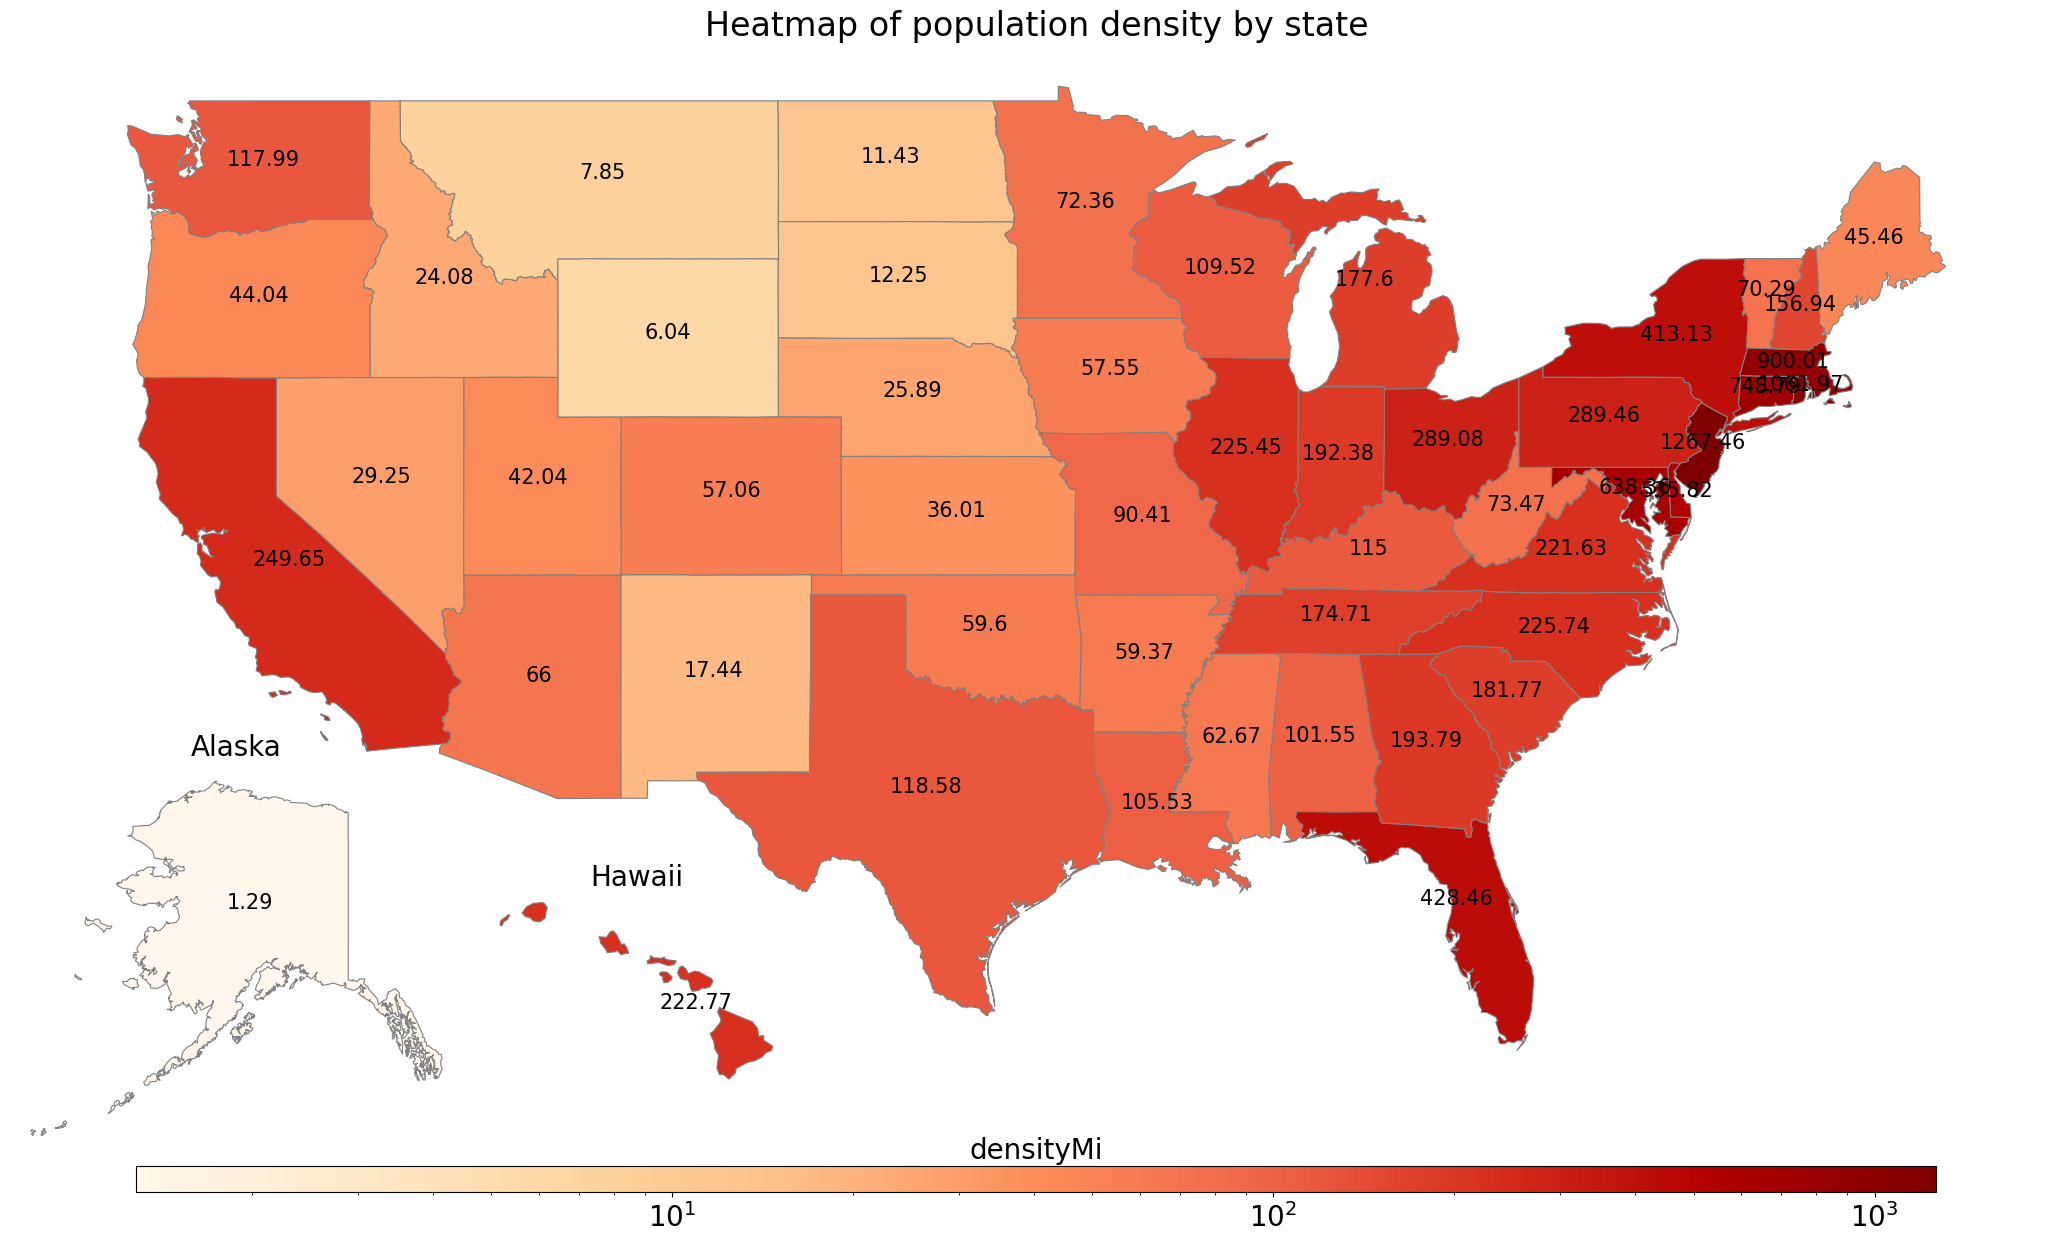

In [36]:
data_column = 'densityMi'

title = f'Heatmap of population density by state'

plot_us_states(map_data,
               data_column,
               title=title,
               colormap='OrRd',
               label_states=True,
               log_scale=True,
               output_file='log population density.png')

# Internet speed

In [37]:
internet_df = pd.read_csv(os.path.join(in_path, 'internet_speed_by_region.csv'))

internet_df.rename(columns={'Region': 'State_Name'}, inplace=True)

internet_df = uppercase_df(internet_df)

internet_df.head()

,State_Name,Internet Speed
0,ALABAMA,84.26
1,ALASKA,35.51
2,ARIZONA,81.22
3,ARKANSAS,63.18
4,CALIFORNIA,94.45


In [38]:
map_data = map_data.merge(internet_df, how='left', on='State_Name')

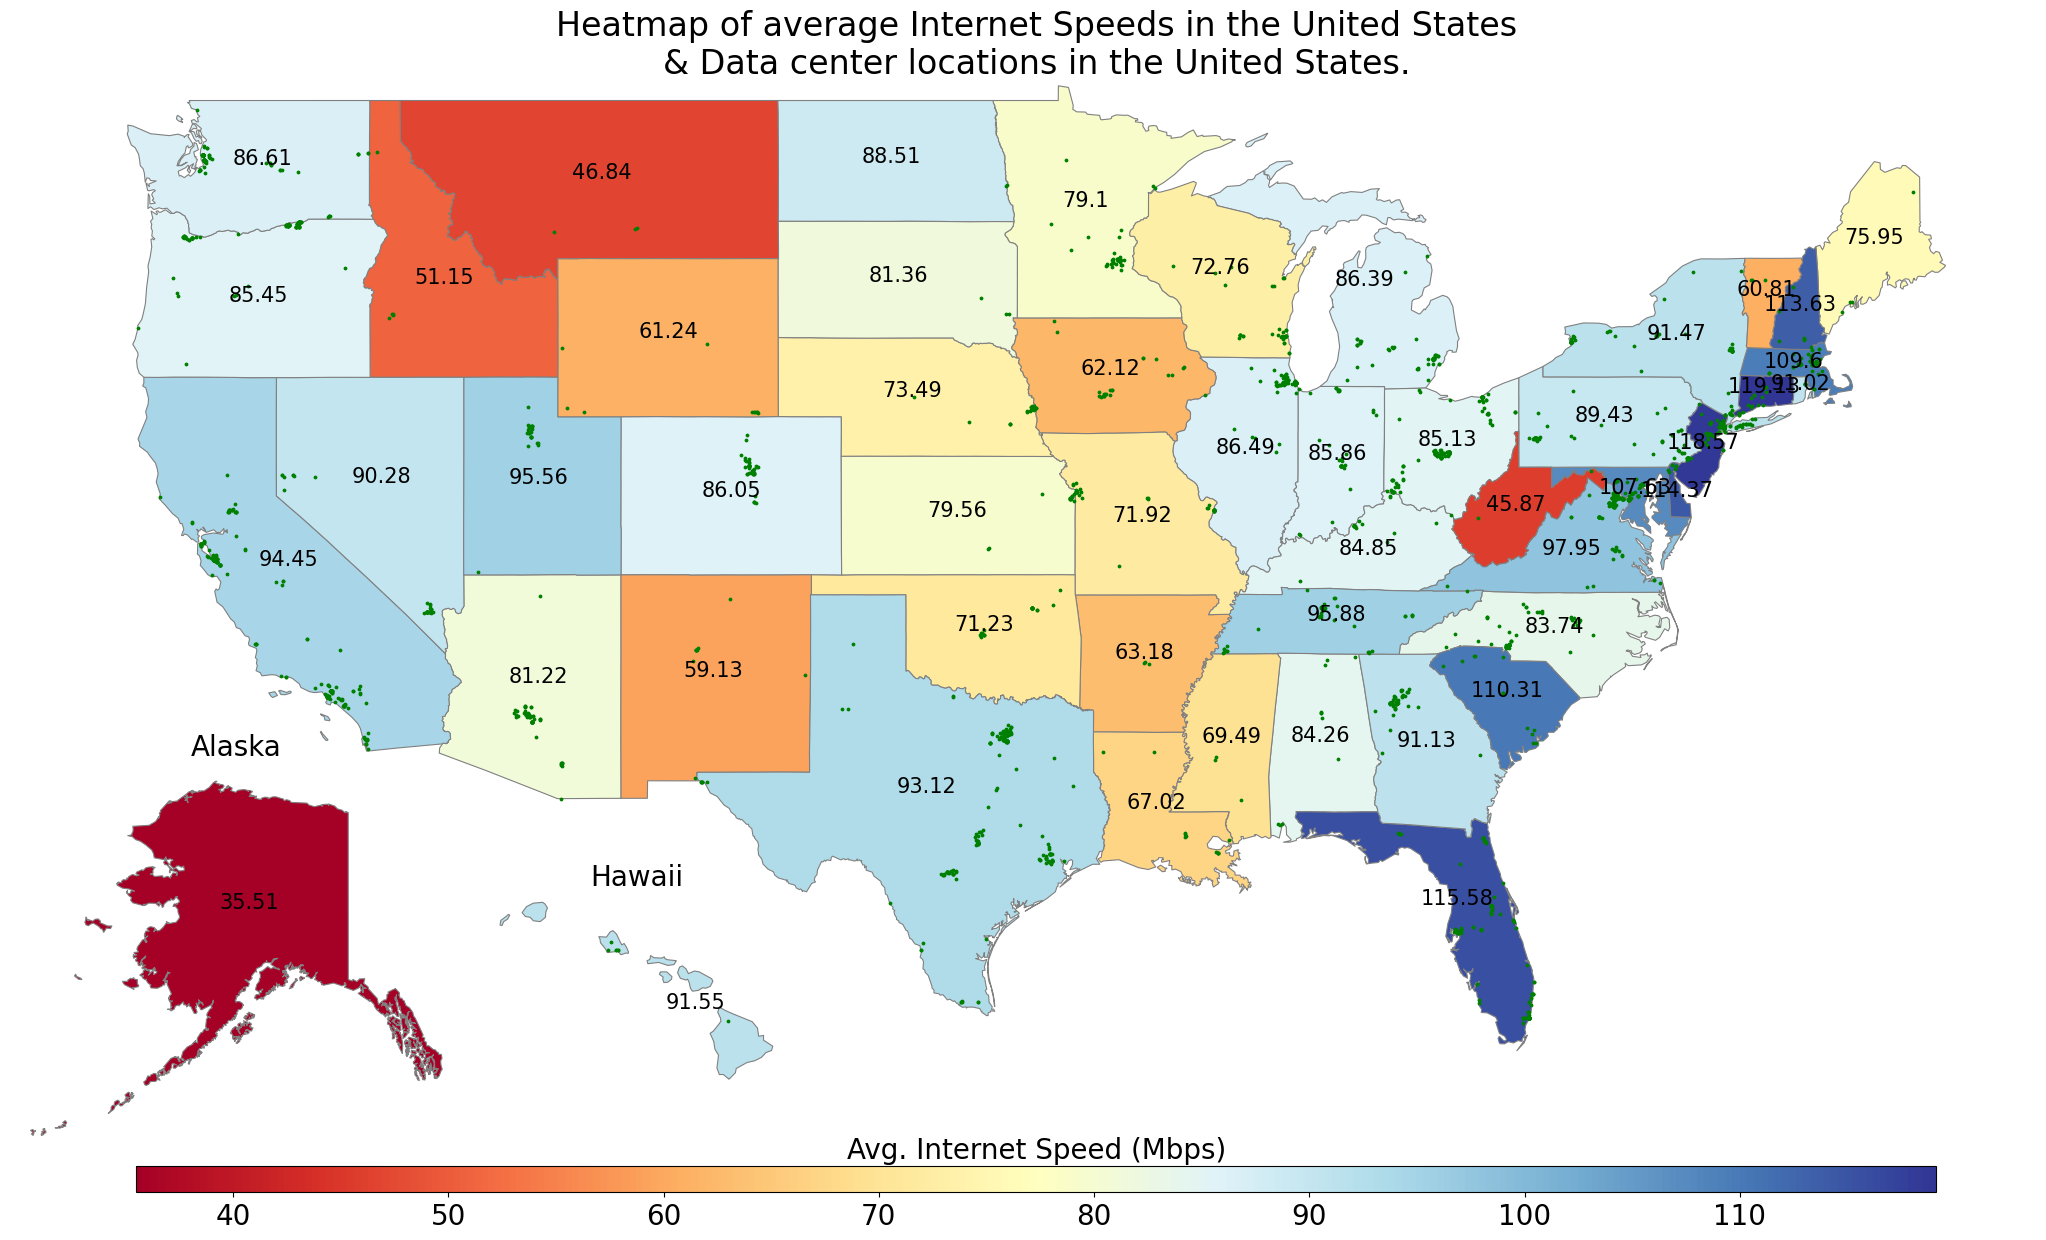

In [39]:
data_column = 'Internet Speed'

title = f'Heatmap of average Internet Speeds in the United States\n& Data center locations in the United States.'

plot_us_states(map_data, 
               data_column, 
               title=title, 
               colorbar_title='Avg. Internet Speed (Mbps)', 
               colormap='RdYlBu', 
               label_states=True,
               plot_points=dc_gdf, 
               point_color='green',
               output_file='avg internet speed and data center locations.png')

# Save statistics from the merged map data as a csv

In [ ]:
columns_to_keep = ['State_Name', 'Datacenter_Count', 'Industrial power price', 'Internet Speed', 'temperature', 'relative_humidity', 'densityMi', 'Renewable']

state_stats = map_data[columns_to_keep]

state_stats.to_csv(os.path.join(out_path, 'state_stats.csv'))